In [1]:
# ! pip install snowflake-connector-python
# ! pip install snowflake-sqlalchemy
# ! pip install sqlalchemy
# ! pip install xgboost

In [2]:
# importing the required libraries
import os
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import root_mean_squared_error,mean_absolute_error

import sqlalchemy
from sqlalchemy import create_engine,text
import snowflake.connector
from sqlalchemy.engine import URL
from snowflake.sqlalchemy import *

import xgboost
from datetime import datetime, timedelta
import time
import pytz
tz_ny = pytz.timezone('Asia/Kolkata')

import warnings
warnings.filterwarnings('ignore')

# importing the snowflake credits
from creds import ACCOUNT,USERNAME,PASSWORD

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


#### LOADING DATA

In [4]:
# Creating the connection engine (way 1)
engine = create_engine(URL(
        account=ACCOUNT,
        user= USERNAME,
        password= PASSWORD,
        role="ACCOUNTADMIN",
        warehouse="COMPUTE_WH",
        database="HEALTH_DB",
        schema="PUBLIC"
    ))

# OR

# # defining the url
# url = f"snowflake://{USERNAME}:{PASSWORD}@{ACCOUNT}/HEALTH_DB/PUBLIC?warehouse=COMPUTE_WH&role=ACCOUNTADMIN"
    
# # creating the engine
# engine = create_engine(url)

In [5]:
# defining the queries to execute
query="""

WITH BASE AS (

    SELECT CASE_ID,
           COALESCE(HOSPITAL_CODE,0) AS HOSPITAL_CODE,
           COALESCE(HOSPITAL_TYPE_CODE,'None') AS HOSPITAL_TYPE_CODE,
           COALESCE(CITY_CODE_HOSPITAL,0) AS CITY_CODE_HOSPITAL,
           COALESCE(HOSPITAL_REGION_CODE,'None') AS HOSPITAL_REGION_CODE,
           COALESCE(AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0) AS AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,
           COALESCE(DEPARTMENT,'None') AS DEPARTMENT,
           COALESCE(WARD_TYPE,'None') AS WARD_TYPE,
           COALESCE(WARD_FACILITY_CODE,'None') AS WARD_FACILITY_CODE,
           COALESCE(BED_GRADE,0) AS BED_GRADE,
           PATIENTID,
           COALESCE(CITY_CODE_PATIENT,0) AS CITY_CODE_PATIENT,
           COALESCE(TYPE_OF_ADMISSION,'None') AS TYPE_OF_ADMISSION,
           COALESCE(SEVERITY_OF_ILLNESS,'Minor') AS SEVERITY_OF_ILLNESS,
           COALESCE(VISITORS_WITH_PATIENT,0) AS VISITORS_WITH_PATIENT,
           COALESCE(AGE,'None') AS AGE,
           COALESCE(ADMISSION_DEPOSIT,0) AS ADMISSION_DEPOSIT,
           ADMISSION_DATE,
           DISCHARGE_DATE

    FROM HEALTH_DB.PUBLIC.HEALTH_DATA

),
    
BASE_WITH_FEATURES AS (

    SELECT *,
            MONTHNAME(ADMISSION_DATE) AS ADMISSION_MONTH,
            DAYNAME(ADMISSION_DATE) AS ADMISSION_DAY,    
            CONCAT(TYPE_OF_ADMISSION,'-',SEVERITY_OF_ILLNESS) AS ADMISSION_ILLNESS,
            CONCAT(SEVERITY_OF_ILLNESS,'-',BED_GRADE) AS ILLNESS_BEDGRADE,
            CONCAT(DEPARTMENT,'-',SEVERITY_OF_ILLNESS) AS DEPARTMENT_ILLNESS,
            DATEDIFF(day,ADMISSION_DATE,DISCHARGE_DATE) AS LOS
    FROM BASE 

)    

SELECT * FROM BASE_WITH_FEATURES



"""

In [6]:
# Connecting to the DB and executing the query
with engine.connect() as conn:
    result = conn.execute(text(query))
    data = pd.DataFrame(result.fetchall())
    data.columns = result.keys()
    data.columns = [col.upper() for col in data.columns.tolist()]

In [7]:
data.shape

(236704, 25)

In [8]:
data.columns

Index(['CASE_ID', 'HOSPITAL_CODE', 'HOSPITAL_TYPE_CODE', 'CITY_CODE_HOSPITAL',
       'HOSPITAL_REGION_CODE', 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
       'DEPARTMENT', 'WARD_TYPE', 'WARD_FACILITY_CODE', 'BED_GRADE',
       'PATIENTID', 'CITY_CODE_PATIENT', 'TYPE_OF_ADMISSION',
       'SEVERITY_OF_ILLNESS', 'VISITORS_WITH_PATIENT', 'AGE',
       'ADMISSION_DEPOSIT', 'ADMISSION_DATE', 'DISCHARGE_DATE',
       'ADMISSION_MONTH', 'ADMISSION_DAY', 'ADMISSION_ILLNESS',
       'ILLNESS_BEDGRADE', 'DEPARTMENT_ILLNESS', 'LOS'],
      dtype='object')

In [9]:
data.head()

,CASE_ID,HOSPITAL_CODE,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,...,AGE,ADMISSION_DEPOSIT,ADMISSION_DATE,DISCHARGE_DATE,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_ILLNESS,ILLNESS_BEDGRADE,DEPARTMENT_ILLNESS,LOS
0,1,8,c,3,Z,3,radiotherapy,R,F,2,...,51-60,4911,2022-08-10,2022-08-20,Aug,Wed,Emergency-Extreme,Extreme-2,radiotherapy-Extreme,10
1,3,10,e,1,X,2,anesthesia,S,E,2,...,51-60,4745,2022-09-09,2022-10-19,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,40
2,4,26,b,2,Y,2,radiotherapy,R,D,2,...,51-60,7272,2022-09-22,2022-11-11,Sep,Thu,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
3,5,26,b,2,Y,2,radiotherapy,S,D,2,...,51-60,5558,2022-11-02,2022-12-22,Nov,Wed,Trauma-Extreme,Extreme-2,radiotherapy-Extreme,50
4,6,23,a,6,X,2,anesthesia,S,F,2,...,51-60,4449,2022-09-16,2022-10-06,Sep,Fri,Trauma-Extreme,Extreme-2,anesthesia-Extreme,20


### DATA PRE-PROCESSING

Writing import statement to utility file

In [10]:
# %%writefile utils.py

# importing the required libraries
import os
import pickle

import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import xgboost

import sqlalchemy
from sqlalchemy import create_engine,text
from sqlalchemy.engine import URL

from snowflake.sqlalchemy import *

import snowflake.connector
from snowflake.connector.pandas_tools import pd_writer
from snowflake.connector.pandas_tools import write_pandas


import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.utils import formatdate
from email import encoders


from datetime import datetime, timedelta
import time
import pytz

tz_ny = pytz.timezone('Asia/Kolkata')

import warnings
warnings.filterwarnings('ignore')




In [11]:
# %%writefile utils.py -a


""" PRE-PROCESSING UTILITY FUNCTION"""

# writing a function for preprocessing
def preprocess_data(data):
    
    # making clone of the data
    df=data.copy()
    
    # defining the columns to drop
    drop_cols = ["HOSPITAL_CODE","PATIENTID",'ADMISSION_DATE','DISCHARGE_DATE']
    # dropping the cols
    df = df.drop(columns=drop_cols)
    
    # setting the CASE_ID as index
    df.set_index("CASE_ID",inplace=True)
    
    # defining the numerical and categorical cols
    num_cols = ["LOS","AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL","ADMISSION_DEPOSIT","VISITORS_WITH_PATIENT"]
    cat_cols = [col for col in df.columns if col not in num_cols]
    
    # fixing the dtypes of the columns
    for col in cat_cols:
        df[col]=df[col].astype(object)
        
    for col in num_cols:
        df[col] = df[col].astype(int)
    
    # doing OHE
    df_ohe = pd.get_dummies(df,dtype=int)
    
    for col in df_ohe.columns:
        if df_ohe[col].dtype==bool:
            df_ohe[col] = df_ohe[col].astype(int)
    
    return df_ohe
    

In [12]:
# preprocessing data
from utils import preprocess_data
df = preprocess_data(data)

In [13]:
df.head()

,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,VISITORS_WITH_PATIENT,ADMISSION_DEPOSIT,LOS,HOSPITAL_TYPE_CODE_a,HOSPITAL_TYPE_CODE_b,HOSPITAL_TYPE_CODE_c,HOSPITAL_TYPE_CODE_d,HOSPITAL_TYPE_CODE_e,HOSPITAL_TYPE_CODE_f,...,DEPARTMENT_ILLNESS_anesthesia-Moderate,DEPARTMENT_ILLNESS_gynecology-Extreme,DEPARTMENT_ILLNESS_gynecology-Minor,DEPARTMENT_ILLNESS_gynecology-Moderate,DEPARTMENT_ILLNESS_radiotherapy-Extreme,DEPARTMENT_ILLNESS_radiotherapy-Minor,DEPARTMENT_ILLNESS_radiotherapy-Moderate,DEPARTMENT_ILLNESS_surgery-Extreme,DEPARTMENT_ILLNESS_surgery-Minor,DEPARTMENT_ILLNESS_surgery-Moderate
CASE_ID,,,,,,,,,,,,,,,,,,,,,
1,3,2,4911,10,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,2,4745,40,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,7272,50,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,2,2,5558,50,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,2,2,4449,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Selection

In [14]:
from sklearn.model_selection import train_test_split

# splitting the target and input features
x = df.drop(columns=['LOS'])
y = df[['LOS']]

# train test splitting
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y)

print(f"The shape of train data {x_train.shape} and {y_train.shape}")
print(f"The shape of test data {x_test.shape} and {y_test.shape}")

The shape of train data (165692, 149) and (165692, 1)
The shape of test data (71012, 149) and (71012, 1)


#### i) Decision Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor

# defining the Dtree
dtree = DecisionTreeRegressor()
# fitting the tree
dtree.fit(x_train,y_train)
# checking the performance
dtree.score(x_train,y_train)

0.9999893173487946

In [16]:
# Checking the feature importance
zipper = dict(zip(x_train.columns,dtree.feature_importances_))

# making it as a dataframe
feature_importances= pd.DataFrame.from_dict(zipper,orient='index').reset_index().rename(columns={"index":"feature",0:"importance"}).sort_values(by='importance',ascending=False)
feature_importances.head()

,feature,importance
1,VISITORS_WITH_PATIENT,0.194751
2,ADMISSION_DEPOSIT,0.159519
30,WARD_TYPE_Q,0.068920
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.038087
100,ADMISSION_MONTH_Nov,0.033330


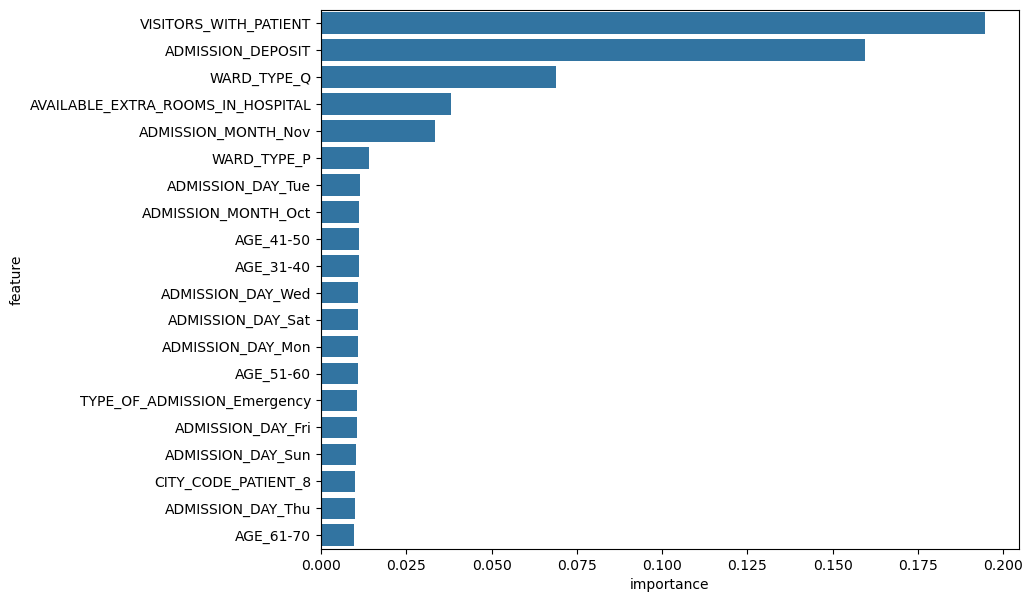

In [17]:
# plotting 
plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='importance',data=feature_importances[:20],orient="h")
plt.show()

In [18]:
# taking the features which have importance greater than threshold 0.01
dtree_features = feature_importances[feature_importances['importance']>0.01]['feature'].values.tolist()
dtree_features

['VISITORS_WITH_PATIENT',
 'ADMISSION_DEPOSIT',
 'WARD_TYPE_Q',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL',
 'ADMISSION_MONTH_Nov',
 'WARD_TYPE_P',
 'ADMISSION_DAY_Tue',
 'ADMISSION_MONTH_Oct',
 'AGE_41-50',
 'AGE_31-40',
 'ADMISSION_DAY_Wed',
 'ADMISSION_DAY_Sat',
 'ADMISSION_DAY_Mon',
 'AGE_51-60',
 'TYPE_OF_ADMISSION_Emergency',
 'ADMISSION_DAY_Fri',
 'ADMISSION_DAY_Sun']

#### ii) XGBoost

In [19]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.42089126999234905

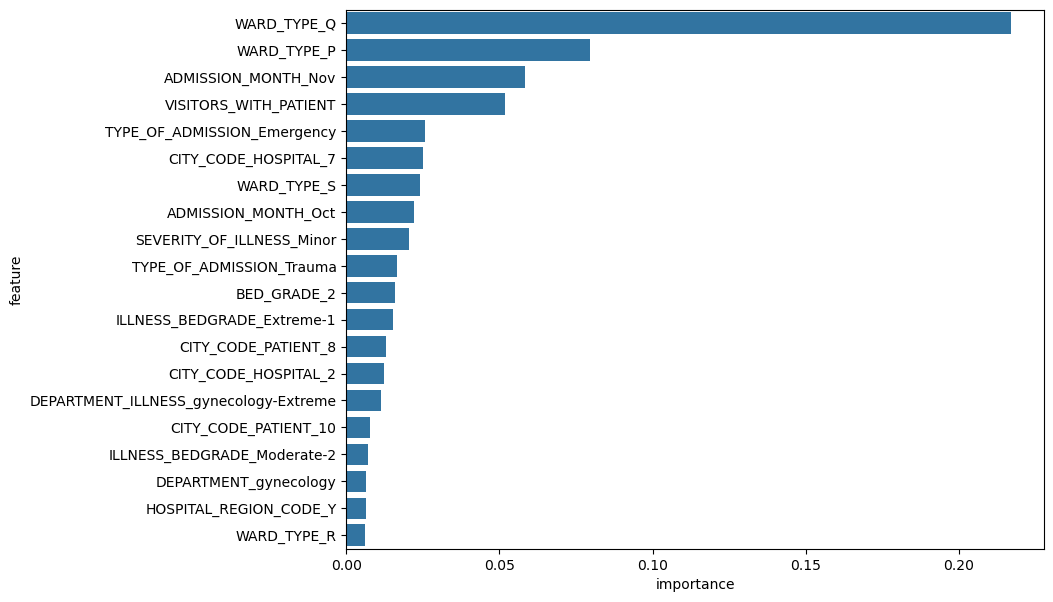

In [20]:
# Checking the feature importance
zipper = dict(zip(x_train.columns,xgb_.feature_importances_))

# making it as a dataframe
xgb_feature_importances= pd.DataFrame.from_dict(zipper,orient='index').reset_index().rename(columns={"index":"feature",0:"importance"}).sort_values(by='importance',ascending=False)
xgb_feature_importances.head()

# plotting 
plt.figure(figsize=(9,7))
sns.barplot(y='feature',x='importance',data=xgb_feature_importances[:20],orient="h")
plt.show()

In [21]:
# taking the features which have importance greater than threshold 0.01
xgb_features = feature_importances[xgb_feature_importances['importance']>0.01]['feature'].values.tolist()
xgb_features

['VISITORS_WITH_PATIENT',
 'WARD_TYPE_Q',
 'ADMISSION_MONTH_Nov',
 'WARD_TYPE_P',
 'ADMISSION_MONTH_Oct',
 'TYPE_OF_ADMISSION_Emergency',
 'CITY_CODE_PATIENT_8',
 'WARD_TYPE_S',
 'BED_GRADE_2',
 'ILLNESS_BEDGRADE_Extreme-1',
 'DEPARTMENT_ILLNESS_gynecology-Extreme',
 'TYPE_OF_ADMISSION_Trauma',
 'SEVERITY_OF_ILLNESS_Minor',
 'CITY_CODE_HOSPITAL_2',
 'CITY_CODE_HOSPITAL_7']

#### Feature Union

In [22]:
# combining the important features from both the models
print(f"Total Features from DTree: {len(dtree_features)}")
print(f"Total Features from XGB: {len(xgb_features)}")

final_features = list(set(dtree_features).union(set(xgb_features)))
final_features

Total Features from DTree: 17
Total Features from XGB: 15


['WARD_TYPE_Q',
 'ADMISSION_DAY_Fri',
 'ADMISSION_DEPOSIT',
 'TYPE_OF_ADMISSION_Trauma',
 'WARD_TYPE_S',
 'VISITORS_WITH_PATIENT',
 'ADMISSION_DAY_Sat',
 'DEPARTMENT_ILLNESS_gynecology-Extreme',
 'WARD_TYPE_P',
 'ADMISSION_DAY_Sun',
 'CITY_CODE_HOSPITAL_7',
 'ADMISSION_DAY_Wed',
 'SEVERITY_OF_ILLNESS_Minor',
 'CITY_CODE_HOSPITAL_2',
 'ADMISSION_DAY_Tue',
 'ILLNESS_BEDGRADE_Extreme-1',
 'AGE_31-40',
 'AGE_41-50',
 'BED_GRADE_2',
 'TYPE_OF_ADMISSION_Emergency',
 'ADMISSION_DAY_Mon',
 'CITY_CODE_PATIENT_8',
 'ADMISSION_MONTH_Nov',
 'AGE_51-60',
 'ADMISSION_MONTH_Oct',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL']

In [23]:
# exporting the data with important features
df[final_features+['LOS']].to_pickle('artifacts/training_data_with_final_features.pkl')

# exporting the list of final features for future predictions
with open('artifacts/final_features.pkl', 'wb') as f:
    pickle.dump(final_features, f)

### MODEL TRAINING

In [24]:
import pickle

# reading the data
df_final_features = pd.read_pickle("artifacts/training_data_with_final_features.pkl")
df_final_features.head()

,WARD_TYPE_Q,ADMISSION_DAY_Fri,ADMISSION_DEPOSIT,TYPE_OF_ADMISSION_Trauma,WARD_TYPE_S,VISITORS_WITH_PATIENT,ADMISSION_DAY_Sat,DEPARTMENT_ILLNESS_gynecology-Extreme,WARD_TYPE_P,ADMISSION_DAY_Sun,...,AGE_41-50,BED_GRADE_2,TYPE_OF_ADMISSION_Emergency,ADMISSION_DAY_Mon,CITY_CODE_PATIENT_8,ADMISSION_MONTH_Nov,AGE_51-60,ADMISSION_MONTH_Oct,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,LOS
CASE_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,4911,0,0,2,0,0,0,0,...,0,1,1,0,0,0,1,0,3,10
3,0,1,4745,1,1,2,0,0,0,0,...,0,1,0,0,0,0,1,0,2,40
4,0,0,7272,1,0,2,0,0,0,0,...,0,1,0,0,0,0,1,0,2,50
5,0,0,5558,1,1,2,0,0,0,0,...,0,1,0,0,0,1,1,0,2,50
6,0,1,4449,1,1,2,0,0,0,0,...,0,1,0,0,0,0,1,0,2,20


In [25]:
# splitting the data into input and target variables
from sklearn.model_selection import train_test_split

x = df_final_features.drop(columns=['LOS'])
y = df_final_features[['LOS']]

# train test splitting
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y)

print(f"The shape of train data {x_train.shape} and {y_train.shape}")
print(f"The shape of test data {x_test.shape} and {y_test.shape}")

The shape of train data (165692, 26) and (165692, 1)
The shape of test data (71012, 26) and (71012, 1)


#### 1. Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error

lr = LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_train,y_train)

0.1822587068416034

In [27]:
y_test_pred = np.ceil(lr.predict(x_test))
rmse = np.sqrt(mean_squared_error(y_test_pred,y_test))
mae = mean_absolute_error(y_test_pred,y_test)
print(f"RMSE is {rmse}")
print(f"MAE is {mae}")

RMSE is 15.179433369906139
MAE is 11.3646989241255


#### 2. Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

y_test_pred = np.ceil(lr.predict(x_test))
rmse = np.sqrt(mean_squared_error(y_test_pred,y_test))
mae = mean_absolute_error(y_test_pred,y_test)
print(f"RMSE is {rmse}")
print(f"MAE is {mae}")

RMSE is 15.179433369906139
MAE is 11.3646989241255


#### 3. Gradient Boosted Decision Tree

In [29]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

y_test_pred = np.ceil(xgb_.predict(x_test))
rmse = root_mean_squared_error(y_test_pred,y_test)
mae = mean_absolute_error(y_test_pred,y_test)
print(f"RMSE is {rmse}")
print(f"MAE is {mae}")

# storing these metrics in model_ref_metric for model drift detection in future
model_ref_metrics = dict()
model_ref_metrics['RMSE'] = rmse
model_ref_metrics['MAE'] = mae

RMSE is 13.616544450377615
MAE is 10.055131527065848


In [30]:
# saving the model_ref_metrics
with open('artifacts/model_ref_metrics.pkl', 'wb') as f:
    pickle.dump(model_ref_metrics, f)

In [31]:
# saving the best model (xgboost)
gbdt = xgb_.get_booster()
gbdt.save_model('artifacts/xgb.model')